****Решение проблемы пропусков в данных


In [1]:
import sklearn
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import *
from scipy.linalg import sqrtm
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.manifold import *
from sklearn.preprocessing import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.neighbors import KNeighborsClassifier
import pickle
from catboost import *
import gc
from collections import *

In [2]:
data = pd.read_parquet("../input/amex-parquet-int/train.parquet")

In [4]:
labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
labels = labels.set_index("customer_ID").astype(np.int16)

In [4]:
types = dict(data.dtypes)

for feature in types.keys():
    if types[feature] == np.int64:
        data[feature] = data[feature].astype(np.int16)
    elif types[feature] == np.float64:
        data[feature] = data[feature].astype(np.float32)

Для начала заполним пропущенные места с помощью линейной интерполяции по индексам, то есть внутри каждого индекса мы сделаем интерполяцию для каждого вещественного признака

In [10]:
cat_features  = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
real_features = [feature for feature in data.columns if feature not in cat_features]

In [ ]:
index_count = Counter(data.index)

In [ ]:
def fill_missing_real(data, index_count):
    row = 0
    
    indexes = data.index
    columns = data.columns
    
    data = data.to_numpy(dtype = np.float32)
    
    curr_part = 0
    
    while row < data.shape[0]:
        
        index = indexes[row]
                
        curr_count = index_count[index]
                
        data_frame = pd.DataFrame(data[row : row + curr_count])
        
        data_frame = data_frame.interpolate(limit_direction = 'both', limit = 13)
        
        data[row : row + curr_count] = data_frame
            
        row += index_count[index]
        
        if row > data.shape[0] / 10 * curr_part:
            print(row, '/', data.shape[0])
            curr_part += 1
            
    return pd.DataFrame(data, columns = columns, index = indexes)

In [ ]:
data[real_features] = fill_missing_real(data[real_features], index_count)

Посмотрим на распределение заполненности признаков, отсеим фичи, у которых пропусков больше 80%

All count : 191
Count of full filled columns : 0
Count more threshold : 169


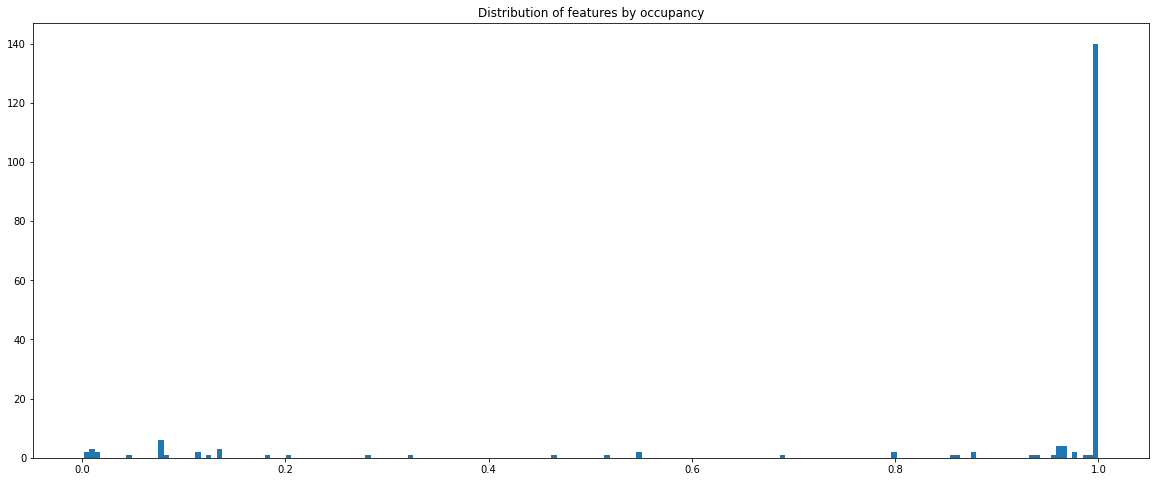

In [6]:
#распределение пропущенных данных в фичах
plt.figure(figsize=[20, 8])

def show_missing_features(data, threshold = 0.2):
    
    filling_features = dict()
    perfect_count = 0
    more_threshold_count = 0
    
    for column in data.columns:
        relation = sum(data[column].notnull()) / data.shape[0]
        
        filling_features[column] = relation

        if relation >= threshold:
            more_threshold_count += 1
        
        elif relation == 1:
            perfect_count += 1
    
    print("All count :", data.shape[1])    
    print("Count of full filled columns :", perfect_count)
    print("Count more threshold :", more_threshold_count)
    
    plt.hist(filling_features.values(), bins = data.shape[1])
    plt.title("Distribution of features by occupancy")
    
    return filling_features
    
filling_features = show_missing_features(data)

In [7]:
threshold = 0.2

dropped_features = [feature for feature in data.columns if filling_features[feature] < 0.2]

data = data.drop(dropped_features, axis=1)

data.shape

(5531451, 169)

In [8]:
cat_features  = [feature for feature in cat_features if feature in data.columns] 
real_features = [feature for feature in data.columns if feature not in cat_features]

Уберем линейнозависимые фичи с помощью предсказания их значений на основе остальных признаков моделями линейной регрессии или классификации, метрики r2_score и roc_auc. При нахождении признака с точностью на кросс валидации выше 0.9 по метрикам убираем его из пространства признаков и остальные предсказываем без него. Выведем гистограмму по точности предсказания и уберем те, у кого выше 0.9.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  UserWarning,


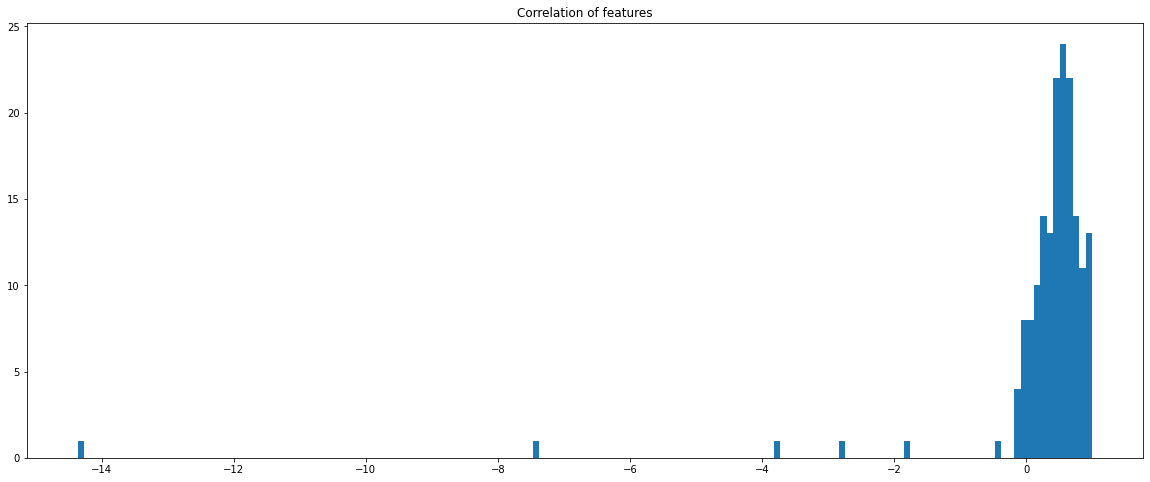

In [9]:
#определение линейной зависимости между фичами 
plt.figure(figsize=[20, 8])


from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

def get_corr_scores(data, features, model, metric, threshold):
    
    scores = dict()
    
    dropped_features = []
    
    data = data.sample(frac=1)
    
    for feature in features:
        
        train  = data.drop(dropped_features, axis=1)
        train  = train.dropna(subset=[feature]).drop([feature], axis=1).fillna(0).to_numpy()
        target = data[feature].to_numpy()
        
        score = np.mean(cross_val_score(model, train, target, cv = 4, scoring = metric))

        if score > threshold:
            dropped_features.append(feature)
                    
        scores[feature] = score
    
    return scores, dropped_features

feature_scores = dict()

dropped_features = []

scores, features = get_corr_scores(data.dropna(), cat_features, SGDClassifier(), "accuracy", 0.9)

feature_scores.update(scores)
dropped_features += features

scores, dropped_features = get_corr_scores(data.dropna(), real_features, LinearRegression(), "r2", 0.9)

feature_scores.update(scores)
dropped_features += features

data = data.drop(dropped_features, axis=1)
cat_features  = [feature for feature in cat_features  if feature in data.columns]
real_features = [feature for feature in real_features if feature in data.columns]
plt.title("Correlation of features")

plt.hist(feature_scores.values(), bins = data.shape[1]);

Для заполнения пропусков заполним разделим признаки на две категории Train и Target. 
Признаки первой категории заполненны свыше 90% их заполним средними значениями вещественные признаки и наиболеее частыми значениями категориальные признаки. 
Признаки второй категории будем заполнять с помощью обучения моделей CatBosstClassifier и CatBoostRegressor на основе Train признаков.

In [10]:
threshold = 0.9

train_features = []
target_features = []

for feature in data.columns:
    
    if filling_features[feature] >= threshold:
        train_features.append(feature)
        
    else:
        target_features.append(feature)

сохраним названия колонок для обработки тестовой выборки

In [11]:
with open("train_features.pkl", "wb") as file:
    pickle.dump(train_features, file)
    
with open("target_features.pkl", "wb") as file:
    pickle.dump(target_features, file)
    
with open("columns.pkl", "wb") as file:
    pickle.dump(list(data.columns), file)

Создадим словарь для дефолтных значений заполненных признаков, сохраним их для тестовой выборки

In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv("../input/amex-default-prediction/train_data.csv", nrows=1)

types = dict(data.dtypes)

for feature in types.keys():
    if types[feature] == np.int64:
        types[feature] = np.int16
    elif types[feature] == np.float64:
        types[feature] = np.float32

In [5]:
#средние значения по всем вещественным признакам 
#самые частые по категориальным

default_values = dict()

default_values.update(dict(data[cat_features].mode().iloc[0]))


for feature in tqdm(real_features):
    default_values[feature] = np.mean(data[feature])


100%|██████████| 180/180 [00:02<00:00, 82.26it/s]


In [ ]:
with open("default_values.pkl", "wb") as file:
    pickle.dump(default_values, file)

In [11]:
def fill_missing_default(data, features, default_values):
    
    for column in features:
        data[column] = data[column].fillna(default_values[column])
        
    return data

data = fill_missing_default(data, train_features, default_values)

Обучим модели для заполнения малозаполненных признаков и увеличим количество записей пользователя до 13, продублировав последнюю известную запись об индексе

In [12]:
def make_repeats(data, index_count, target_count):
    repeats = []
    index = 0
    dobavka = 0
    while index < data.shape[0]:
        curr_count = index_count[data.index[index]]
        ness_count = target_count - curr_count
        ness_el = data.iloc[index + curr_count - 1]
        
        for i in range(ness_count):
            repeats.append(ness_el)
            
        index += curr_count
    
    data = data.append(repeats)
    
    return data.sort_index()
    
    
def fill_missing_by_model(data,  model, train_features, target_features, train = True):
    row = 0
            
    mask = data[target_features].notnull()
        
    for feature in tqdm(target_features):
        
        if train:
            train_data = data[train_features][mask[feature]][: data.shape[0] // 3]
            labels     = data[feature][mask[feature]][: data.shape[0] // 3]
        
            model_ = model
        
            model_.fit(train_data, labels)
            
            pickle.dump(model_, open(feature + "_model", "wb"))
            
            del train_data
            del labels
        
        else:
            model_ = pickle.load(open("../input/train-all-fill/" + feature + "_model", 'rb'))
            
        test_data = data[~mask[feature]][train_features]
        
        result = model_.predict(test_data)
        
        
        data[feature][~mask[feature]] = result
    
        del result
        del model_
        gc.collect()
        
    return data       

In [15]:
cat_feature_models  = []
real_feature_models = []

cat_target_features  = [feature for feature in target_features if feature in cat_features]
real_target_features = [feature for feature in target_features if feature in real_features]


data = fill_missing_by_model(data, CatBoostClassifier(iterations = 300), train_features, cat_target_features,  False)

data = fill_missing_by_model(data, CatBoostRegressor(iterations = 300),  train_features, real_target_features, False)

0it [00:00, ?it/s]
  0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 14/14 [01:48<00:00,  7.78s/it]


Создадим новые признаки target encoding на основе категориальных с регуляризацией alpha = 10, сохраним значения для тестовой выборки

In [2]:
data = pd.read_parquet("../input/amex-parquet-int-inter/train.parquet")

In [7]:
def make_targets_for_index(labels, index_count):
    
    row = 0
    
    targets = []
    indexes = []
    
    for index in labels.index:
        targets += index_count[index] * [labels.loc[index, "target"]]
        indexes += index_count[index] * [index]
    
    return pd.DataFrame({"target" : targets}, index = indexes)

index_target = make_targets_for_index(labels, index_count)

In [12]:
def make_target_feature(data, labels, cat_features, alpha=10):
    
    glob_mean = sum(labels["target"]) / labels.shape[0]
    
    target_features = dict()

    data["target"] = labels["target"].values
    
    for feature in tqdm(cat_features):
        
        count_values = Counter(data[feature].fillna(0))
        
        value_targets = dict()
        
        for value in count_values.keys():
            
            k = count_values[value]
            
            mean = sum(data["target"][data[feature] == value]) / k
            
            value_targets[value] = (mean * k + glob_mean * alpha) / (k + alpha)
        
        target_features[feature] = value_targets
    
    data = data.drop(["target"], axis=1)
    
    return target_features

In [13]:
cat_targets = make_target_feature(data, index_target, cat_features)

100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


In [14]:
with open("cat_targets.pkl", "wb") as file:
    pickle.dump(cat_targets, file)

In [25]:
for feature in tqdm(cat_features):
    
    data[feature + "_target"] = data[feature]
    
    data[feature + "_target"] = data[feature + "_target"].replace(cat_targets[feature])

100%|██████████| 9/9 [00:00<00:00, 15.05it/s]


In [26]:
data.to_parquet("data_fill_all.parquet")

In [ ]:
data = make_repeats(data, index_count, 13)

In [ ]:
data.to_parquet("train_repeat.parquet")

In [ ]:
# # Заполненность данными отдельных наблюдений

# def plot_distribution(filling, count_more_threshold, threshold_obj, class_name, grid_num):
    
#     count_obj = len(filling)
    
#     print("Count of {0}: {1}\n".format(class_name, count_obj))
    
#     print("Threshold  {0}:".format(class_name), threshold_obj)
#     print("Percent of {0} filled more threshold: {1}%".format(class_name, int(count_more_threshold / count_obj  * 100)))
#     print("Count   of {0} more treshold / all: {1} / {2}\n".format(class_name, count_more_threshold, count_obj))
    
#     plt.subplot(grid_num)
#     plt.hist(filling)
#     plt.title("Distribution of {0} objects by occupancy".format(class_name))
    
#     return 

# def get_indexes_filling_data(data, threshold_obj, threshold_index, index_count = index_count):
    
#     relation_objs = data.notnull().mean(axis=1)
    
#     more_threshold_index   = []
#     more_threshold_objects = []
    
#     filling_index = {}
#     filling_objects   = []
    
#     row = 0
    
#     while row < relation_objs.shape[0]:
        
#         index = relation_objs.index[row]
        
#         relations_index = relation_objs.loc[index]
        
#         if relations_index.shape == ():
#             relations_index = [relations_index]
            
#         count_more_threshold = 0

#         for row_index in range(len(relations_index)):
            
#             relation = relations_index[row_index]
            
#             if relation >= threshold_obj:
#                 count_more_threshold += 1
#                 more_threshold_objects.append(row + row_index)
                
#             filling_objects.append(relation)

#         relation = count_more_threshold / index_count[index]
        
#         if relation >= threshold_index:
#             more_threshold_index.append(index)
            
#         filling_index[index] = relation
        
#         row += index_count[index]
        
#     return filling_objects, filling_index, more_threshold_index, more_threshold_objects




# obj_threshold   = 0.85

# pos_threshold   = 0.75
# neg_threshold   = 0.84

# index_threshold = 0.8


# #data_filling, data_indexes = get_indexes_filling_data(dataset.data,                        labels,                        obj_threshold)
# pos_filling_obj, pos_filling_indexes, pos_indexes, pos_obj  = get_indexes_filling_data(dataset.data[labels["target"] == 1], pos_threshold, index_threshold)
# neg_filling_obj, neg_filling_indexes, neg_indexes, neg_obj  = get_indexes_filling_data(dataset.data[labels["target"] == 0],  neg_threshold, index_threshold)

# new_indexes =  pos_indexes + neg_indexes

In [ ]:
# plt.figure(figsize=[20,8])

# grid = plt.GridSpec(2, 2)

# #plot_distribution(data_filling, len(data_indexes), obj_threshold, "all",      grid[1, :2])
# plot_distribution(pos_filling_obj,  len(pos_obj),  pos_threshold, "positive objects", grid[0, 0])
# plot_distribution(neg_filling_obj,  len(neg_obj),  neg_threshold, "negative objects", grid[0, 1])

# print("Result")

# print("Old relation between classes: {0} : {1}".format(int(dataset.data[labels["target"] == 1].shape[0] / dataset.data.shape[0] * 100), 
#                                                        int(dataset.data[labels["target"] == 0].shape[0] / dataset.data.shape[0] * 100)))

# print("New relation between classes: {0} : {1}".format(int(len(pos_obj) / (len(pos_obj) + len(neg_obj)) * 100), 
#                                                        int(len(neg_obj) / (len(pos_obj) + len(neg_obj)) * 100)))

In [ ]:
# plt.figure(figsize=[20,8])

# grid = plt.GridSpec(2, 2)

# #plot_distribution(data_filling, len(data_indexes), obj_threshold, "all",      grid[1, :2])
# plot_distribution(pos_filling_indexes.to_numpy(dtype = np.float32)(), len(pos_indexes), pos_threshold, "positive indexes", grid[0, 0])
# plot_distribution(neg_filling_indexes.to_numpy(dtype = np.float32)(), len(neg_indexes), neg_threshold, "negative indexes", grid[0, 1])

# print("Result")

# print("Old relation between indexes: {0} : {1}".format(int(dataset.data[labels["target"] == 1].shape[0] / dataset.data.shape[0] * 100), 
#                                                        int(dataset.data[labels["target"] == 0].shape[0] / dataset.data.shape[0] * 100)))

# print("New relation between indexes: {0} : {1}".format(int(len(pos_indexes) / (len(pos_indexes) + len(neg_indexes)) * 100), 
#                                                        int(len(neg_indexes) / (len(pos_indexes) + len(neg_indexes)) * 100)))
